# project: medallions
- goal predict number of total rides

## Imports

In [2]:
# Section 1: Deep Learning (Keras)
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
from math import sqrt

# Section 2: Time Series Forecasting (Prophet, ARIMA and SARIMAX)
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Section 3: Utility Libraries
import itertools
from itertools import product
import numpy as np
import pandas as pd
import locale
from math import sqrt
from IPython.display import display, HTML

# Section 4: Data Transformation
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

# Section 5: Performance Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import ParameterGrid


# Section 6: Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

# ORganize
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from pmdarima import auto_arima
import pandas as pd
from math import sqrt
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from math import sqrt
from sklearn.model_selection import ParameterGrid
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf


In [3]:
display(HTML("<style>div.output_scroll { height: 10em; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


## Data Pre-Processing

In [4]:
data_reports_monthly = pd.read_csv('data_reports_monthly.csv')
data_reports_monthly.columns = data_reports_monthly.columns.str.strip()

# Make month/year index
data_reports_monthly['Month/Year'] = pd.to_datetime(data_reports_monthly['Month/Year'])
data_reports_monthly.set_index('Month/Year', inplace=True)

# Replace commas
data_reports_monthly = data_reports_monthly.replace({',': ''}, regex=True)

# Convert numeric columns to numeric
cols = data_reports_monthly.columns.drop(['License Class'])
data_reports_monthly[cols] = data_reports_monthly[cols].apply(pd.to_numeric, errors='coerce')

# Calculate Avg Trips per Vehicle
data_reports_monthly['Avg Trips per Vehicle'] = data_reports_monthly['Trips Per Day'] / data_reports_monthly['Vehicles Per Day']

# Create a new DataFrame with relevant columns
df = data_reports_monthly[['License Class', 'Trips Per Day']].copy()

# Calculate total NYC rides per Month/Year and assign the values to 'Total NYC Rides' column
df['Total NYC Rides'] = df.groupby('Month/Year')['Trips Per Day'].sum()

# Calculate the percentage of total rides
df['Percent of Total'] = df['Trips Per Day'] / df['Total NYC Rides']

# Get a list of unique license classes
license_classes = df['License Class'].unique()

# Sort Index

index = pd.to_datetime(df.index)
df = df.sort_index()
print(df.index.is_monotonic_increasing)


True


# Predict Total Rides

## Selecting a Model

In [295]:

# Preprocessing
# Get the time series for 'Total NYC Rides' and remove duplicates
series = df['Total NYC Rides'].drop_duplicates()

# Convert series to float data type
series = series.astype(float)

# Split into train and test sets
train, test = series[:-10], series[-10:]

# Set the frequency of the time series
train.index.freq = 'MS'

# AUTO ARIMA (SARIMAX equivalent) Model
auto_sarimax_model = auto_arima(train, seasonal=True, m=12, trace=False)
auto_sarimax_predictions = auto_sarimax_model.predict(n_periods=len(test))
auto_sarimax_rmse = sqrt(mean_squared_error(test, auto_sarimax_predictions))

# SARIMAX Model
sarimax_model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 12))
sarimax_model_fit = sarimax_model.fit(disp=False)
sarimax_predictions = sarimax_model_fit.get_forecast(steps=len(test)).predicted_mean

# Holt-Winters Model
hw_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')
hw_model_fit = hw_model.fit()
hw_predictions = hw_model_fit.predict(start=test.index[0], end=test.index[-1])

# Prophet Model
prophet_df = pd.DataFrame({'ds': train.index, 'y': train.values})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
prophet_future = prophet_model.make_future_dataframe(periods=len(test), freq='MS')
prophet_predictions = prophet_model.predict(prophet_future)['yhat'].tail(len(test))

# Calculate RMSE for each model
auto_sarimax_rmse = sqrt(mean_squared_error(test, auto_sarimax_predictions))
sarimax_rmse = sqrt(mean_squared_error(test, sarimax_predictions))
hw_rmse = sqrt(mean_squared_error(test, hw_predictions))
prophet_rmse = sqrt(mean_squared_error(test, prophet_predictions))

# Print RMSE for each model
print(f'auto_arima Test RMSE: {auto_sarimax_rmse:.3f}')
print(f'SARIMAX Test RMSE: {sarimax_rmse:.3f}')
print(f'Holt-Winters Test RMSE: {hw_rmse:.3f}')
print(f'Prophet Test RMSE: {prophet_rmse:.3f}')


10:41:05 - cmdstanpy - INFO - Chain [1] start processing
10:41:05 - cmdstanpy - INFO - Chain [1] done processing


auto_arima Test RMSE: 36698.654
SARIMAX Test RMSE: 40996.703
Holt-Winters Test RMSE: 29793.593
Prophet Test RMSE: 101000.759


## Shallow Dive into Prophet, Can it be better?

In [296]:
# Adjust to predict Total NYC Rides

# Get the time series for 'Total NYC Rides' and remove duplicates
series = df['Total NYC Rides'].drop_duplicates()

# Convert series to float data type
series = series.astype(float)

# Split into train and test sets
train, test = series[:-10], series[-10:]

# Create a DataFrame for Prophet
prophet_df = pd.DataFrame({'ds': train.index, 'y': train.values})

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False],
    'seasonality_prior_scale': [10,20,50]
}

# Perform grid search
best_rmse = float('inf')
best_model = None

for params in ParameterGrid(param_grid):
    try:
        # Create and fit Prophet model with current parameter combination
        prophet_model = Prophet(**params)
        prophet_model.fit(prophet_df)
        
        # Make future dataframe for predictions
        prophet_future = prophet_model.make_future_dataframe(periods=len(test), freq='MS')
        
        # Make predictions
        prophet_predictions = prophet_model.predict(prophet_future)['yhat'].tail(len(test))
        
        # Calculate RMSE
        rmse = sqrt(mean_squared_error(test, prophet_predictions))
        
        # Update best model if RMSE improves
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = prophet_model
    except:
        continue

# Print best model's parameters and RMSE
if best_model is not None:
    print('Best Model Parameters:')
    print(best_model.params)
    print(f'Best Model Test RMSE: {best_rmse:.3f}')
else:
    print('No model was found.')


10:41:18 - cmdstanpy - INFO - Chain [1] start processing
10:41:18 - cmdstanpy - INFO - Chain [1] done processing
10:41:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:41:18 - cmdstanpy - INFO - Chain [1] start processing
10:41:18 - cmdstanpy - INFO - Chain [1] done processing
10:41:18 - cmdstanpy - INFO - Chain [1] start processing
10:41:18 - cmdstanpy - INFO - Chain [1] done processing
10:41:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:41:18 - cmdstanpy - INFO - Chain [1] start processing
10:41:18 - cmdstanpy - INFO - Chain [1] done processing
10:41:19 - cmdstanpy - INFO - Chain [1] start processing
10:41:19 - cmdstanpy - INFO - Chain [1] done processing
10:41:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Best Model Parameters:
OrderedDict([('lp__', array([[188.937]])), ('k', array([[0.272499]])), ('m', array([[0.464922]])), ('delta', array([[ 1.90908e-09,  5.95730e-09, -6.04448e-09,  1.00318e-08,
        -7.94792e-09, -7.33907e-09,  4.70367e-08,  2.82849e-08,
         1.58291e-06,  9.83085e-09, -2.61393e-09,  6.38698e-09,
         9.05558e-09, -4.56866e-09, -1.39229e-10, -1.01106e-10,
         3.26432e-09, -9.44987e-04, -2.44386e-09,  2.52075e-09,
        -1.72661e-09, -1.89388e-08,  1.71313e-08, -1.41105e-08,
         1.01592e-09]])), ('sigma_obs', array([[0.171442]])), ('beta', array([[ 1.65814e-03,  2.22198e-02,  7.21112e-04, -6.85611e-03,
         9.42423e-03, -2.31452e-03, -1.89266e-03, -4.53456e-03,
         8.95167e-07, -4.20191e-03, -3.09949e-04, -3.41785e-03,
        -1.07366e-03, -2.75562e-03,  2.06039e-03, -1.88101e-03,
        -9.00532e-03, -2.06912e-03,  2.96176e-03, -5.10392e-03]])), ('trend', array([[0.464922, 0.466798, 0.468492, 0.470368, 0.472184, 0.47406 ,
        0.4

## Testing Optimizers

          Method          RMSE           MAE
0   basinhopping  16823.787699  14274.513661
1  least_squares  16756.841234  14295.803309
2       L-BFGS-B  25775.213431  19068.077319
3            TNC  31174.925942  25389.600219
4          SLSQP  29793.593010  22774.751419
5         Powell  16995.443850  14375.859026
6   trust-constr  29794.086614  22776.752565


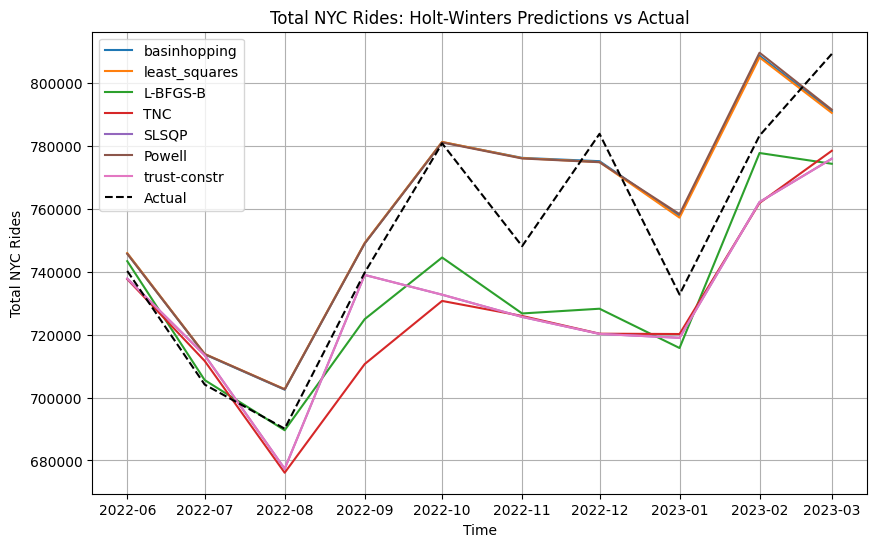

In [333]:
# Function to handle data preprocessing
def preprocess_data(df, column):
    series = df[column].copy()
    
    # Aggregate data by taking the mean for each timestamp
    series = series.groupby(level=0).mean()
    
    # Remove duplicates and convert to float
    series = series.drop_duplicates().astype(float)
    
    return series

def split_data(series, test_size):
    # Resample the series to month start frequency
    series = series.resample('MS').mean()
    train, test = series[:-test_size], series[-test_size:]
    
    return train, test

# Preprocess the data
series = preprocess_data(df, 'Total NYC Rides')

# Split into train and test sets
train, test = split_data(series, 3)

# Function to fit the model and make predictions
def fit_and_predict(train, test, method):
    hw_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')
    hw_model_fit = hw_model.fit(method=method)
    predictions = hw_model_fit.predict(start=test.index[0], end=test.index[-1])
    return predictions

# Function to evaluate the model
def evaluate_model(test, predictions):
    rmse = np.sqrt(mean_squared_error(test.values, predictions))
    mae = mean_absolute_error(test.values, predictions)
    return rmse, mae

series = preprocess_data(df, 'Total NYC Rides')
train, test = split_data(series, 10)
methods = ['basinhopping', 'least_squares', 'L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr']

results_df = pd.DataFrame(index=test.index)
rmse_dict = {}
mae_dict = {}

for method in methods:
    try:
        predictions = fit_and_predict(train, test, method)
        if len(predictions) == len(test):
            results_df[method] = predictions
            rmse, mae = evaluate_model(test, predictions)
            rmse_dict[method] = rmse
            mae_dict[method] = mae
        else:
            results_df[method] = np.nan
            rmse_dict[method] = np.nan
            mae_dict[method] = np.nan
    except Exception as e:
        print(f'Failed to fit model with {method}, due to {str(e)}')
        results_df[method] = np.nan
        rmse_dict[method] = np.nan
        mae_dict[method] = np.nan

results_df['Actual'] = test.values

# Print the RMSE and MAE DataFrame
eval_df = pd.DataFrame(list(rmse_dict.items()), columns=['Method', 'RMSE'])
eval_df['MAE'] = mae_dict.values()
print(eval_df)

# Plot the actual values and the predicted values from each method
plt.figure(figsize=(10,6))
for method in methods:
    plt.plot(results_df.index, results_df[method], label=method)
plt.plot(results_df.index, results_df['Actual'], label='Actual', color='black', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.title('Total NYC Rides: Holt-Winters Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Total NYC Rides')
plt.show()


## Check mle_retvals
- Create a dataframe to print out message and success for each model ran


In [398]:
model_fit.mle_retvals

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1488.3158399017082
       x: [ 1.000e+00  6.610e-05 ...  1.009e+00  1.007e+00]
     nit: 9
   direc: [[ 1.845e-20  1.469e-38 ...  3.031e-21  4.355e-21]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 3.067e-06  0.000e+00 ...  1.588e-04 -3.358e-04]]
    nfev: 2128

## Test Transformations

In [551]:
# Prepare the data

# Get the time series for 'Total NYC Rides' and remove duplicates
series = df['Total NYC Rides'].drop_duplicates()

# Convert series to float data type
series = series.astype(float)

# Split into train and test sets
train, test = series[:-10], series[-10:]

# Set the frequency of the time series
train.index.freq = 'MS'

In [552]:
def transform_data(series):
    """
    Transform a pandas Series using different methods and return a dictionary of transformed data.
    
    series : pd.Series
        The input data to be transformed.
    """
    assert not series.isna().any(), 'The series contains NaN values.'
    
    transformations = {
        'non_transformed': {'data': series, 'type': 'non_transformed'},
        'log_transformed': None,
        'sqrt_transformed': None,
        'cube_root_transformed': {'data': np.cbrt(series), 'type': 'cube_root_transformed'},
        'differenced': {'data': series.diff().dropna(), 'type': 'differenced'}
    }
    
    try:
        transformations['log_transformed'] = {'data': np.log(series), 'type': 'log_transformed'}
    except ValueError:
        print("Log transformation not possible due to non-positive values.")

    try:
        transformations['sqrt_transformed'] = {'data': np.sqrt(series), 'type': 'sqrt_transformed'}
    except ValueError:
        print("Square root transformation not possible due to negative values.")

    return transformations

In [554]:
# Create an empty DataFrame to store predictions
predictions_df = pd.DataFrame(index=test.index)

def fit_and_predict(transformed_series_info, method, original_series):
    try:
        model = ExponentialSmoothing(transformed_series_info['data'], seasonal_periods=12, trend='add', seasonal='add')
        fit = model.fit(method=method)
        predictions = fit.predict(start=test.index[0], end=test.index[-1])

        if transformed_series_info['type'] == 'log_transformed':
            predictions = np.exp(predictions)
        elif transformed_series_info['type'] == 'sqrt_transformed':
            predictions = np.power(predictions, 2)
        elif transformed_series_info['type'] == 'cube_root_transformed':
            predictions = np.power(predictions, 3)
        elif transformed_series_info['type'] == 'differenced':
            predictions = predictions.cumsum()
            predictions = predictions + original_series.iloc[0]

        # Store the predictions in the DataFrame
        predictions_df[method + '_' + transformed_series_info['type']] = predictions

        if len(predictions) == len(test):
            return np.sqrt(mean_squared_error(test.values, predictions))
        else:
            return np.nan
    except Exception as e:
        print(f'Failed to fit model with {method}, due to {str(e)}')
        return np.nan



In [555]:
transformations = transform_data(train)

rmse_df = pd.DataFrame(index=['basinhopping', 'least_squares', 'L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr'])

for name, transformed_series_info in transformations.items():
    for method in rmse_df.index:
        rmse_df.loc[method, name] = fit_and_predict(transformed_series_info, method, train)


In [556]:
predictions_df

,basinhopping_non_transformed,least_squares_non_transformed,L-BFGS-B_non_transformed,TNC_non_transformed,SLSQP_non_transformed,Powell_non_transformed,trust-constr_non_transformed,basinhopping_log_transformed,least_squares_log_transformed,L-BFGS-B_log_transformed,TNC_log_transformed,SLSQP_log_transformed,Powell_log_transformed,trust-constr_log_transformed,basinhopping_sqrt_transformed,least_squares_sqrt_transformed,L-BFGS-B_sqrt_transformed,TNC_sqrt_transformed,SLSQP_sqrt_transformed,Powell_sqrt_transformed,trust-constr_sqrt_transformed,basinhopping_cube_root_transformed,least_squares_cube_root_transformed,L-BFGS-B_cube_root_transformed,TNC_cube_root_transformed,SLSQP_cube_root_transformed,Powell_cube_root_transformed,trust-constr_cube_root_transformed,basinhopping_differenced,least_squares_differenced,L-BFGS-B_differenced,TNC_differenced,SLSQP_differenced,Powell_differenced,trust-constr_differenced
Month/Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-01,745877.635708,745921.750102,743380.559004,737659.680595,737836.817845,745691.615250,737838.400639,756647.760517,756644.823671,756648.779767,750300.181504,756648.003248,754852.803727,756648.009663,749995.413327,749996.798301,750077.445243,737234.104541,741473.534178,748475.687817,736594.529233,751849.565500,751851.984333,751851.551853,747039.195097,751849.940235,750177.809144,736112.269345,481484.484630,480135.668917,477535.205174,473205.865696,477705.423211,482120.595317,477058.548125
2022-07-01,713809.127927,713868.833530,705554.335732,711643.038852,713480.707746,713818.784000,713471.841491,726503.481843,726495.873103,726503.307088,709325.446580,726504.120286,724524.952121,726504.217159,718851.606767,718861.129984,718997.276046,701409.417361,697198.214229,716398.840993,707245.422066,721024.475442,721027.912476,721025.207849,717397.557964,721024.743409,718350.742249,704901.432419,449647.122210,446656.900405,443335.597085,439652.050330,442796.402361,450625.522224,441537.502310
2022-08-01,702577.802917,702669.916856,689599.326912,676085.000877,677340.007061,702593.787744,677351.895889,709582.128635,709573.407932,709577.517735,683583.758609,709582.709329,708301.002481,709582.851330,705163.942194,705175.537667,705318.003656,683178.863049,676505.172955,702543.201322,661649.874839,706361.964616,706366.786249,706362.475317,693475.662250,706360.668848,703572.669724,655852.173420,438329.443339,434029.521281,419460.889934,417466.256586,419642.596631,439984.450900,418757.997919
2022-09-01,749041.591069,749171.916797,724925.534550,710644.946617,739003.177156,748985.237842,738988.496428,773408.284097,773405.106955,773398.145300,732764.640051,773409.774671,772698.896792,773408.915086,758797.693609,758815.561694,758912.334944,728635.566796,716380.118265,756515.423488,737742.527744,762990.806595,762996.612931,762990.605477,737838.521527,762988.590734,760632.662667,737260.018202,486252.227589,479111.048701,470905.085864,452971.991943,467254.412727,487044.295571,465279.290391
2022-10-01,781227.961649,781311.666835,744541.553650,730728.139375,732705.587545,781140.096646,732726.423877,807594.696440,807588.539386,807581.840056,761191.873654,807597.132644,808155.751311,807595.338779,791481.390012,791495.203096,791527.886589,757453.817479,738657.443149,789939.332525,729940.906745,796043.231225,796048.328034,796046.178561,769913.330791,796041.479521,794606.576593,728885.514118,519075.957679,509819.281907,484767.986735,444686.217711,482927.028011,519741.889581,482342.095615
2022-11-01,776126.612503,776147.416800,726743.009097,725948.566504,725647.806329,776040.941309,725643.712063,797319.003034,797314.452105,797306.976361,750751.976825,797319.976838,798706.536568,797319.575907,784072.428018,784083.756933,784068.241896,739423.139286,717433.566547,783362.594169,721830.161890,787763.456877,787769.031397,787768.182058,759597.287959,787762.086182,787360.602695,720395.683867,513902.879093,503230.013616,478569.517133,439711.189460,473947.177701,515135.481945,473621.248715
2022-12-01,774935.081866,774892.0831

In [557]:

overprediction_weight = 1
underprediction_weight = 4

def asymmetric_mean_absolute_percentage_error(y_true, y_pred, overprediction_weight, underprediction_weight):
    """
    Calculates AMAPE given y_true and y_pred
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    residual = (y_true - y_pred) / y_true
    return np.mean(
        np.where(residual < 0, -overprediction_weight * residual, underprediction_weight * residual)) * 100

def fit_and_predict(transformed_series_info, method, original_series):
    """
    This function fits the model, makes predictions, and then calculates the RMSE, MAE, MAPE, AMAPE, and MaxP.
    It returns these errors and the predictions.
    """
    try:
        model = ExponentialSmoothing(transformed_series_info['data'], seasonal_periods=12, trend='add', seasonal='add')
        fit = model.fit(method=method)
        predictions = fit.predict(start=test.index[0], end=test.index[-1])

        if transformed_series_info['type'] == 'log_transformed':
            predictions = np.exp(predictions)
        elif transformed_series_info['type'] == 'sqrt_transformed':
            predictions = np.power(predictions, 2)
        elif transformed_series_info['type'] == 'cube_root_transformed':
            predictions = np.power(predictions, 3)
        elif transformed_series_info['type'] == 'differenced':
            predictions = predictions.cumsum()
            predictions = predictions + original_series.iloc[0]

        # Create percentage diff dataframe
        percentage_diff = abs((predictions - test.values) / test.values) * 100
        maxp = percentage_diff.max()

        if len(predictions) == len(test):
            rmse = np.sqrt(mean_squared_error(test.values, predictions))
            mae = mean_absolute_error(test.values, predictions)
            mape = mean_absolute_percentage_error(test.values, predictions)
            amape = asymmetric_mean_absolute_percentage_error(test.values, predictions, overprediction_weight, underprediction_weight)
            return rmse, mae, mape, amape, maxp, predictions
        else:
            return np.nan, np.nan, np.nan, np.nan, np.nan, predictions
    except Exception as e:
        print(f'Failed to fit model with {method}, due to {str(e)}')
        return np.nan, np.nan, np.nan, np.nan, np.nan, predictions

# Initialize dataframes
rmse_df = pd.DataFrame(index=methods)
mae_df = pd.DataFrame(index=methods)
mape_df = pd.DataFrame(index=methods)
amape_df = pd.DataFrame(index=methods)
maxp_df = pd.DataFrame(index=methods)

# Perform the fit and predict for each transformation and method
for name, transformed_series_info in transformations.items():
    for method in methods:
        rmse, mae, mape, amape, maxp, _ = fit_and_predict(transformed_series_info, method, train)
        rmse_df.loc[method, name] = rmse
        mae_df.loc[method, name] = mae
        mape_df.loc[method, name] = mape
        amape_df.loc[method, name] = amape
        maxp_df.loc[method, name] = maxp

# Convert to float
rmse_df = rmse_df.astype(float)
mae_df = mae_df.astype(float)
mape_df = mape_df.astype(float)
amape_df = amape_df.astype(float)
maxp_df = maxp_df.astype(float)

# Sort DataFrames
rmse_df_sorted = rmse_df.unstack().sort_values()
mae_df_sorted = mae_df.unstack().sort_values()
mape_df_sorted = mape_df.unstack().sort_values()
amape_df_sorted = amape_df.unstack().sort_values()
maxp_df_sorted = maxp_df.unstack().sort_values()

# Print Sorted DataFrames
print("RMSE DataFrame Sorted by Best Score:")
print(rmse_df_sorted)

print("\nMAE DataFrame Sorted by Best Score:")
print(mae_df_sorted)

print("\nMAPE DataFrame Sorted by Best Score:")
print(mape_df_sorted)

print("\nAMAPE DataFrame Sorted by Best Score:")
print(amape_df_sorted)

print("\nMaxP DataFrame Sorted by Best Score:")
print(maxp_df_sorted)


RMSE DataFrame Sorted by Best Score:
cube_root_transformed  TNC               15006.769589
log_transformed        TNC               15696.078013
non_transformed        least_squares     16756.841234
                       basinhopping      16770.652995
                       Powell            16995.443850
sqrt_transformed       TNC               18444.442840
                       Powell            21430.450702
                       basinhopping      21574.949149
                       least_squares     21580.985431
                       L-BFGS-B          21582.953023
cube_root_transformed  basinhopping      24342.312572
                       SLSQP             24342.601847
                       L-BFGS-B          24347.244442
                       least_squares     24347.878608
                       Powell            24368.896656
non_transformed        L-BFGS-B          25775.213431
                       SLSQP             29793.593010
                       trust-constr      2979

## Select top Models

In [527]:
mae_top_5_models = mae_df_sorted.index[:10].map('{0[1]}_{0[0]}'.format)
mape_top_5_models = mape_df_sorted.index[:10].map('{0[1]}_{0[0]}'.format)
rmse_top_5_models = rmse_df_sorted.index[:10].map('{0[1]}_{0[0]}'.format)
amape_top_5_models = amape_df_sorted.index[:10].map('{0[1]}_{0[0]}'.format)
maxp_top_5_models = maxp_df_sorted.index[:10].map('{0[1]}_{0[0]}'.format)


In [528]:
from collections import Counter

# Convert to lists
mae_models = mae_top_5_models.tolist()
mape_models = mape_top_5_models.tolist()
rmse_models = rmse_top_5_models.tolist()
amape_models = amape_top_5_models.tolist()
maxp_models = maxp_top_5_models.tolist()

# Combine lists
combined = mae_models + mape_models + rmse_models + amape_models + maxp_models

# Count frequencies
counter = Counter(combined)

# Create DataFrame
df = pd.DataFrame.from_dict(counter, orient='index', columns=['Count'])

# Sort DataFrame by Count
df_sorted = df.sort_values(by='Count', ascending=False)

print(df_sorted)


                                     Count
Powell_non_transformed                   5
Powell_sqrt_transformed                  5
least_squares_sqrt_transformed           5
basinhopping_sqrt_transformed            5
L-BFGS-B_sqrt_transformed                5
TNC_cube_root_transformed                4
basinhopping_non_transformed             4
least_squares_non_transformed            4
TNC_log_transformed                      3
TNC_sqrt_transformed                     3
basinhopping_cube_root_transformed       2
SLSQP_cube_root_transformed              2
Powell_cube_root_transformed             1
L-BFGS-B_cube_root_transformed           1
least_squares_cube_root_transformed      1


In [529]:
combined

['TNC_log_transformed',
 'TNC_cube_root_transformed',
 'TNC_sqrt_transformed',
 'basinhopping_non_transformed',
 'least_squares_non_transformed',
 'Powell_non_transformed',
 'Powell_sqrt_transformed',
 'least_squares_sqrt_transformed',
 'basinhopping_sqrt_transformed',
 'L-BFGS-B_sqrt_transformed',
 'TNC_log_transformed',
 'TNC_cube_root_transformed',
 'TNC_sqrt_transformed',
 'basinhopping_non_transformed',
 'least_squares_non_transformed',
 'Powell_non_transformed',
 'Powell_sqrt_transformed',
 'least_squares_sqrt_transformed',
 'basinhopping_sqrt_transformed',
 'L-BFGS-B_sqrt_transformed',
 'TNC_cube_root_transformed',
 'TNC_log_transformed',
 'basinhopping_non_transformed',
 'least_squares_non_transformed',
 'Powell_non_transformed',
 'TNC_sqrt_transformed',
 'Powell_sqrt_transformed',
 'basinhopping_sqrt_transformed',
 'least_squares_sqrt_transformed',
 'L-BFGS-B_sqrt_transformed',
 'Powell_sqrt_transformed',
 'Powell_cube_root_transformed',
 'L-BFGS-B_cube_root_transformed',
 'ba

## Top Model Evaluations

### Prediction vs. Actual Line Plot

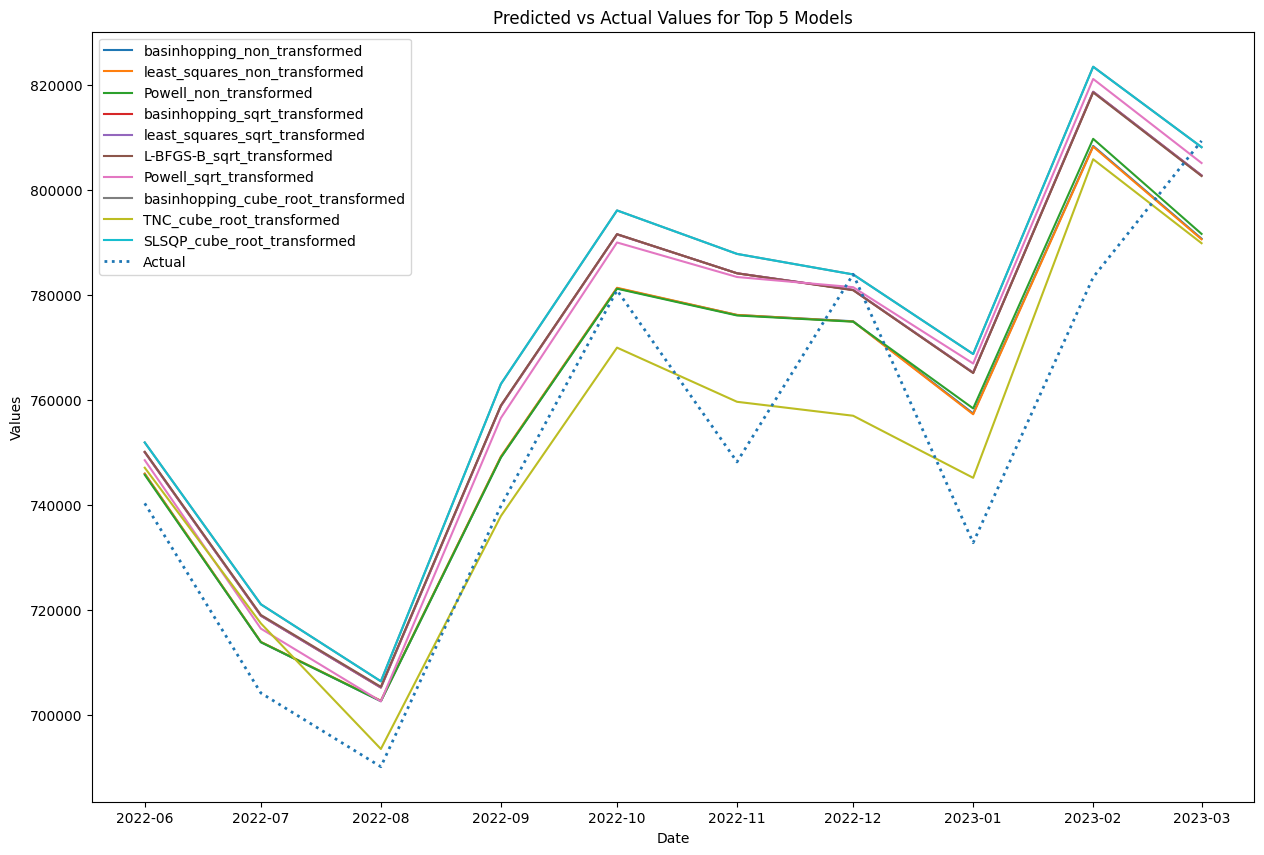

In [558]:
# maxp_top_5_models

# Plotting the predictions and actual values
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the predicted valued of top 5 models
for column in predictions_df.columns:
    if column in maxp_top_5_models:
        ax.plot(predictions_df.index, predictions_df[column], label=column)

# Plot the actual values
ax.plot(test.index, test.values, label='Actual', linestyle=':', linewidth=2)

ax.set_title('Predicted vs Actual Values for Top 5 Models')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.legend(loc='best')
plt.show()


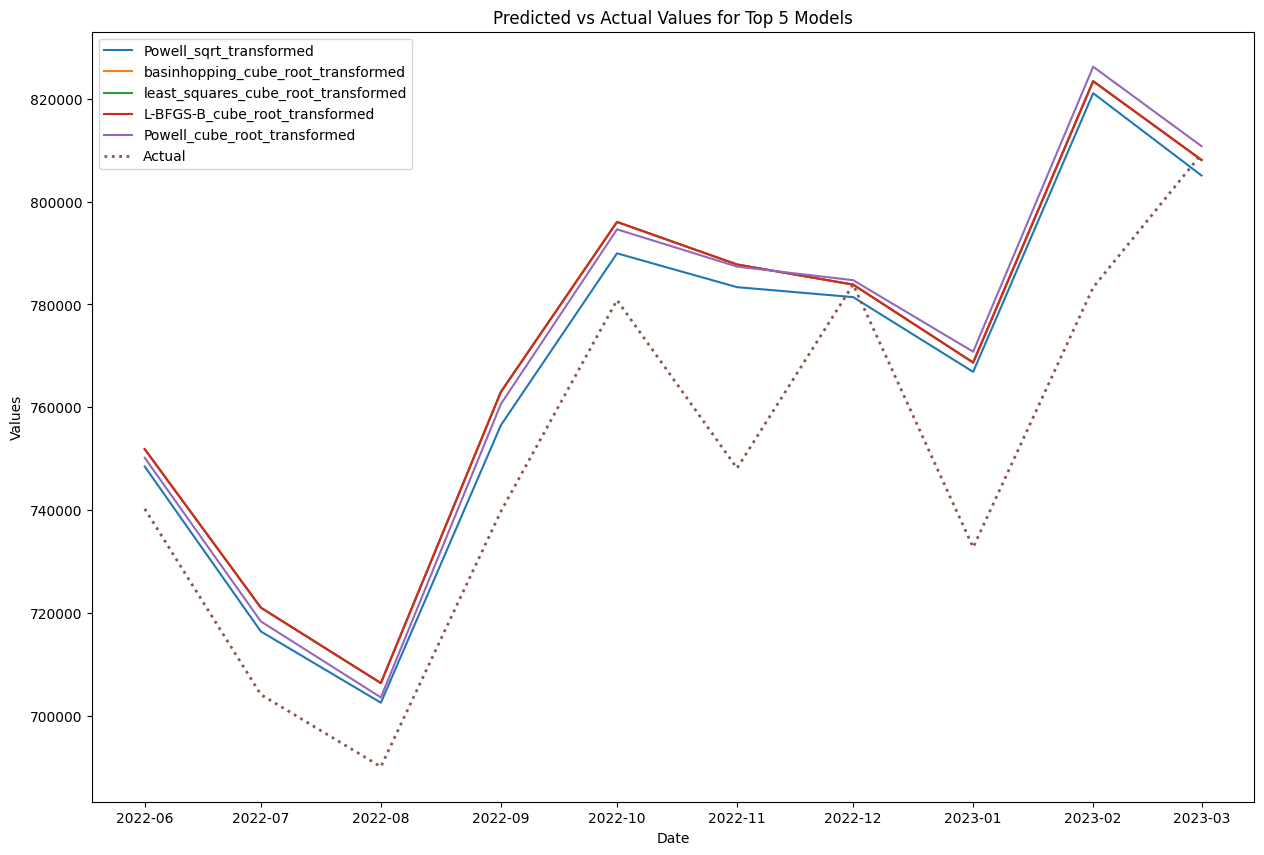

In [443]:
# amape_top_5_models

# Plotting the predictions and actual values
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the predicted valued of top 5 models
for column in predictions_df.columns:
    if column in amape_top_5_models:
        ax.plot(predictions_df.index, predictions_df[column], label=column)

# Plot the actual values
ax.plot(test.index, test.values, label='Actual', linestyle=':', linewidth=2)

ax.set_title('Predicted vs Actual Values for Top 5 Models')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.legend(loc='best')
plt.show()


### Bar Chart RMSE / Metrics

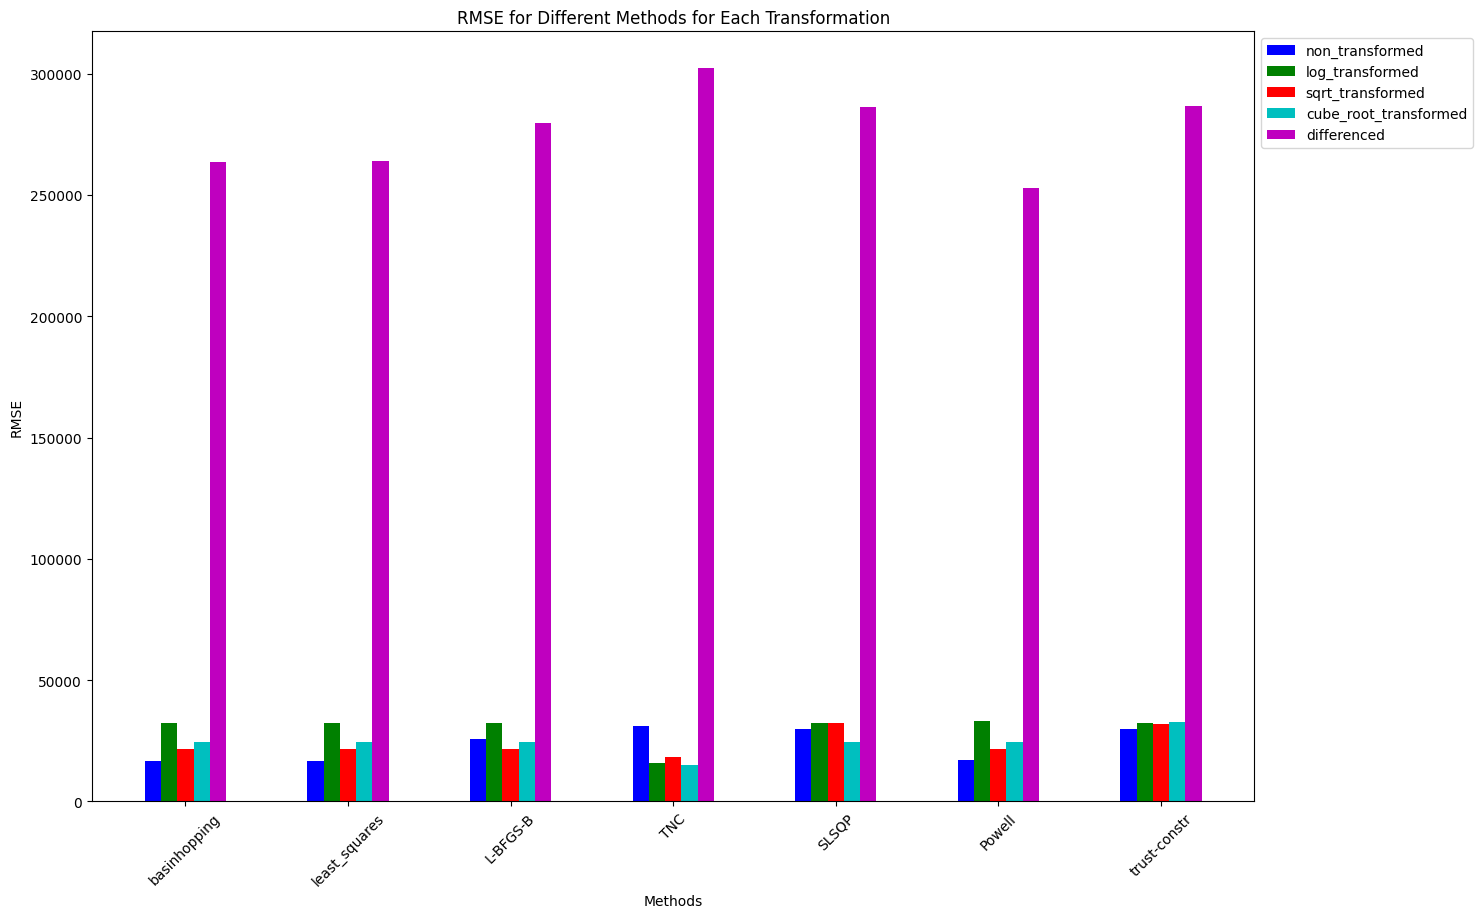

In [341]:
fig, ax = plt.subplots(figsize=(15, 10))

colors = ['b', 'g', 'r', 'c', 'm']

for i, name in enumerate(transformations.keys()):
    ax.bar(np.array(range(len(rmse_df.index))) + i*0.1, rmse_df[name], 
           width=0.1, color=colors[i], align='center', label=name)

ax.set_xticks(np.array(range(len(rmse_df.index))) + 0.2)
ax.set_xticklabels(rmse_df.index, rotation=45)
ax.set_title('RMSE for Different Methods for Each Transformation')
ax.set_xlabel('Methods')
ax.set_ylabel('RMSE')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

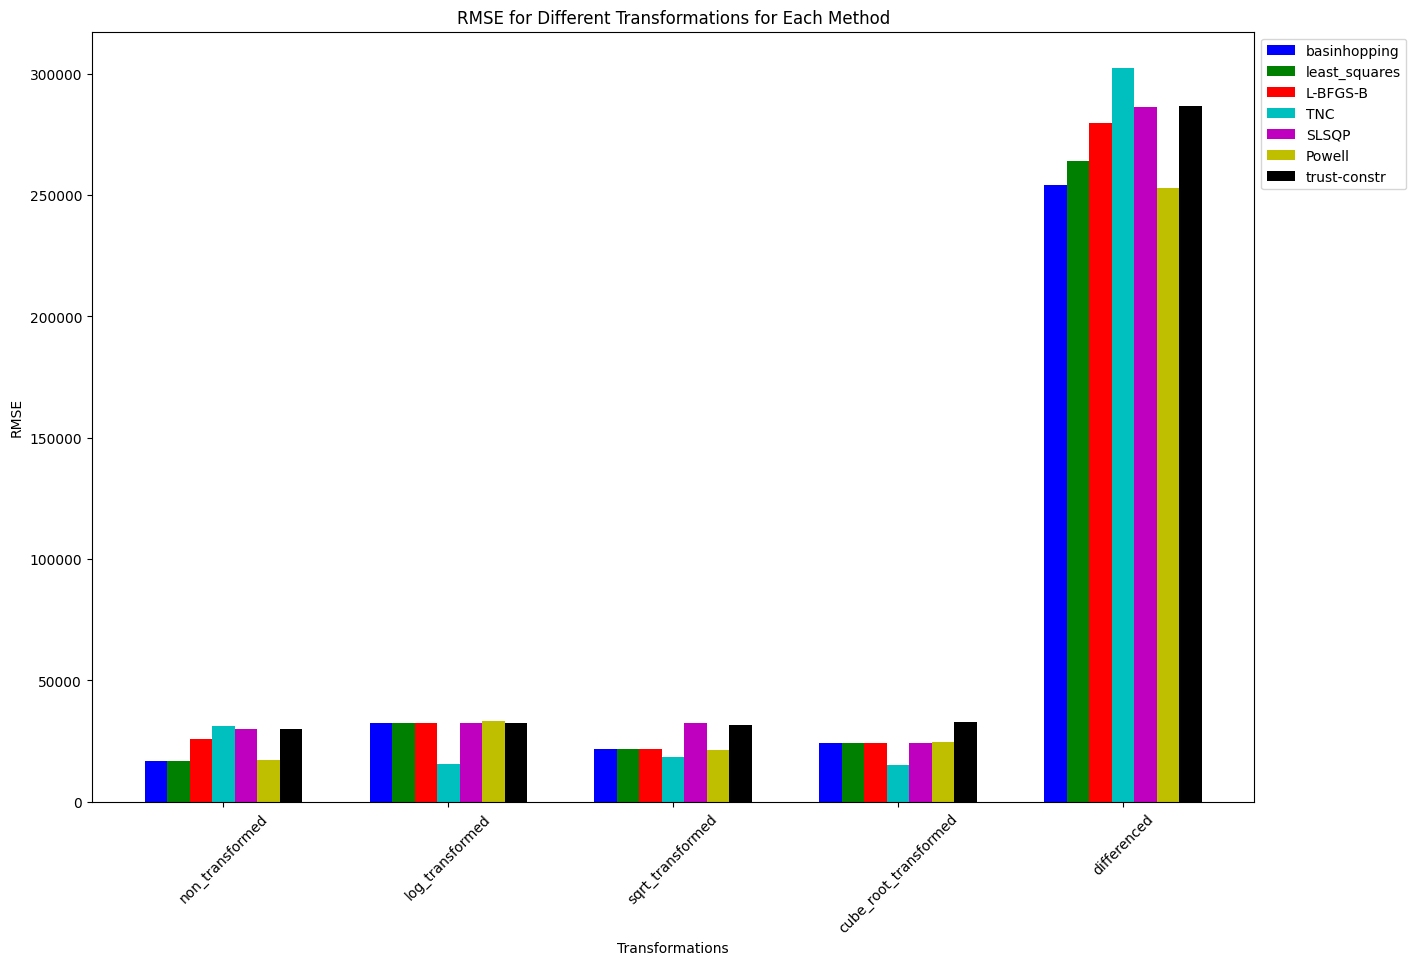

In [326]:
# Transpose the DataFrame so that the transformations are the columns
transposed_rmse_df = rmse_df.transpose()

fig, ax = plt.subplots(figsize=(15, 10))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] # added extra colors for more methods

# Enumerate through the columns (methods) of the transposed DataFrame
for i, method in enumerate(transposed_rmse_df.columns):
    ax.bar(np.array(range(len(transposed_rmse_df.index))) + i*0.1, transposed_rmse_df[method], 
           width=0.1, color=colors[i], align='center', label=method)

ax.set_xticks(np.array(range(len(transposed_rmse_df.index))) + 0.3) # Adjust for added bar
ax.set_xticklabels(transposed_rmse_df.index, rotation=45)
ax.set_title('RMSE for Different Transformations for Each Method')
ax.set_xlabel('Transformations')
ax.set_ylabel('RMSE')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()


## Gridsearch

In [542]:
# Get the time series for 'Total NYC Rides' and remove duplicates
series = df['Total NYC Rides'].drop_duplicates()

# Convert series to float data type
series = series.astype(float)

# Split into train and test sets
train, test = series[:-12], series[-12:]

# Set the frequency of the time series
train.index.freq = 'MS'

# Define the optimization methods to try
methods = ['basinhopping', 'least_squares','L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr']


# Define the parameters to search over
param_grid = {'trend': ['add', 'mul'], 'seasonal': ['add', 'mul'], 'seasonal_periods': [4, 12], 'damped_trend': [True, False]}
fit_methods = ['basinhopping', 'least_squares', 'L-BFGS-B', 'TNC', 'SLSQP', 'Powell']

# Create a list of parameter combinations
grid = list(ParameterGrid(param_grid))

results = []

# Loop through each combination of parameters
for params in grid:
    for fit_method in fit_methods:
        try:
            model = ExponentialSmoothing(train, **params)
            model_fit = model.fit(method=fit_method)
            predictions = model_fit.predict(start=test.index[0], end=test.index[-1])
            rmse = np.sqrt(mean_squared_error(test, predictions))
            results.append({'params': params, 'fit_method': fit_method, 'rmse': rmse})
        except Exception as e:
            print(f"Error for parameters {params} and method {fit_method}: {e}")
            continue

# Find the parameters that gave the lowest RMSE
best_params = min(results, key=lambda x: x['rmse'])

print(f"Best parameters: {best_params['params']}")
print(f"Best Fit Method: {best_params['fit_method']}")
print(f"Best RMSE: {best_params['rmse']}")


ValueError: Inferred frequency -1MS from passed values does not conform to passed frequency MS

In [124]:
# Check mle_retvals
model_fit.mle_retvals

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 494573886381.60565
       x: [ 1.000e+00  1.907e-01 ...  1.016e+00  1.022e+00]
     nit: 8
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 6.043e-09  2.692e-03 ...  5.664e-04  1.327e-03]]
    nfev: 1767

## Evaluating Best Fit Model

In [355]:
# Get the time series for 'Total NYC Rides' and remove duplicates
series = df['Total NYC Rides'].drop_duplicates()

# Convert series to float data type
series = series.astype(float)

# Split into train and test sets
train, test = series[:-12], series[-12:]

# Set the frequency of the time series
train.index.freq = 'MS'

# Re-fit the model with the best parameters and fit method
best_model = ExponentialSmoothing(train, **best_params['params'])
best_model_fit = best_model.fit(method=best_params['fit_method'])

# Make predictions
best_predictions = best_model_fit.predict(start=test.index[0], end=test.index[-1])

# Create a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({'Actual': test, 'Predicted': best_predictions})
comparison_df['Difference'] = comparison_df['Actual'] - comparison_df['Predicted']
comparison_df['Difference_Percentage'] = comparison_df['Difference'] / comparison_df['Actual'] * 100

# add a line of blank space
print()

print('Evaluation Metrics:')
# Calculate RMSE
rmse = sqrt(mean_squared_error(comparison_df['Actual'], comparison_df['Predicted']))
print(f'RMSE: {rmse:.3f}')
# Calculate RMSE as a percentage (Accuracy)
rmse_percentage = rmse / comparison_df['Actual'].mean() * 100
print(f'RMSE Percentage (Accuracy): {rmse_percentage:.3f}%')
# Calculate MAPE
mape = np.mean(np.abs(comparison_df['Difference'] / comparison_df['Actual'])) * 100
print(f'MAPE: {mape:.3f}%')
# Calculate MAE
mae = mean_absolute_error(comparison_df['Actual'], comparison_df['Predicted'])
print(f'MAE: {mae:.3f}')

# Print the comparison DataFrame
comparison_df



Evaluation Metrics:
RMSE: 15027.386
RMSE Percentage (Accuracy): 2.001%
MAPE: 1.597%
MAE: 12255.022


,Actual,Predicted,Difference,Difference_Percentage
2022-04-01,755386.0,732053.084822,23332.915178,3.088873
2022-05-01,743735.0,733417.457596,10317.542404,1.387261
2022-06-01,740256.0,735572.030367,4683.969633,0.632750
2022-07-01,704132.0,703466.345787,665.654213,0.094535
2022-08-01,690095.0,692305.745633,-2210.745633,-0.320354
2022-09-01,739744.0,738760.414070,983.585930,0.132963
2022-10-01,780844.0,770898.856724,9945.143276,1.273640
2022-11-01,748147.0,765842.479054,-17695.479054,-2.365241
2022-12-01,783886.0,764814.464803,19071.535197,2.432948
2023-01-01,732754.0,747324.389254,-14570.389254,-1.988442


In [130]:
# Check mle_retvals
model_fit.mle_retvals

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 494573886381.60565
       x: [ 1.000e+00  1.907e-01 ...  1.016e+00  1.022e+00]
     nit: 8
   direc: [[ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 6.043e-09  2.692e-03 ...  5.664e-04  1.327e-03]]
    nfev: 1767

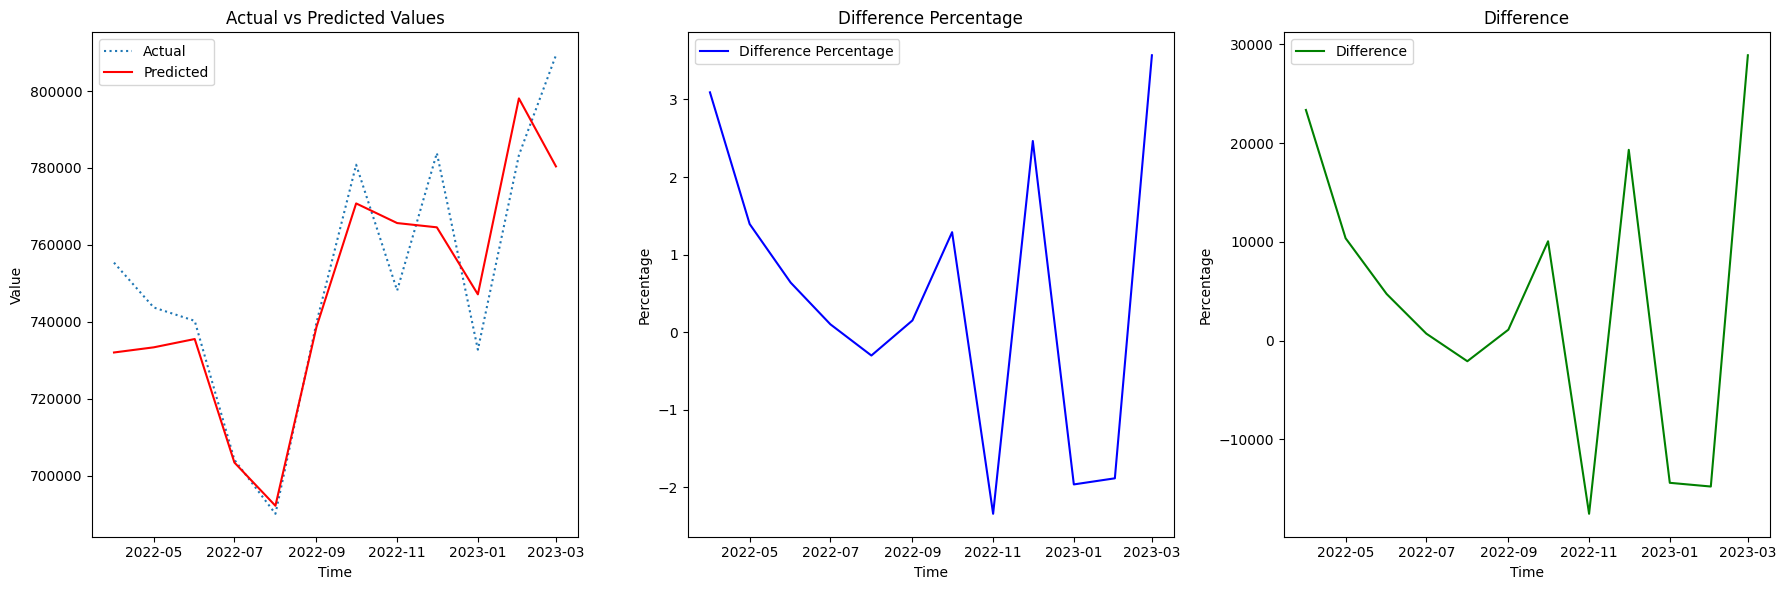

In [126]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot actual vs predicted values
axs[0].plot(comparison_df['Actual'], linestyle='dotted', label='Actual')
axs[0].plot(comparison_df['Predicted'], color='red', label='Predicted')
axs[0].set_title('Actual vs Predicted Values')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')
axs[0].legend()

# Plot difference percentage
axs[1].plot(comparison_df['Difference_Percentage'], color='blue', label='Difference Percentage')
axs[1].set_title('Difference Percentage')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Percentage')
axs[1].legend()

# Plot difference
axs[2].plot(comparison_df['Difference'], color='green', label='Difference')
axs[2].set_title('Difference')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Percentage')
axs[2].legend()

plt.tight_layout()
plt.show()


## Checking Assumptions

### Residuals

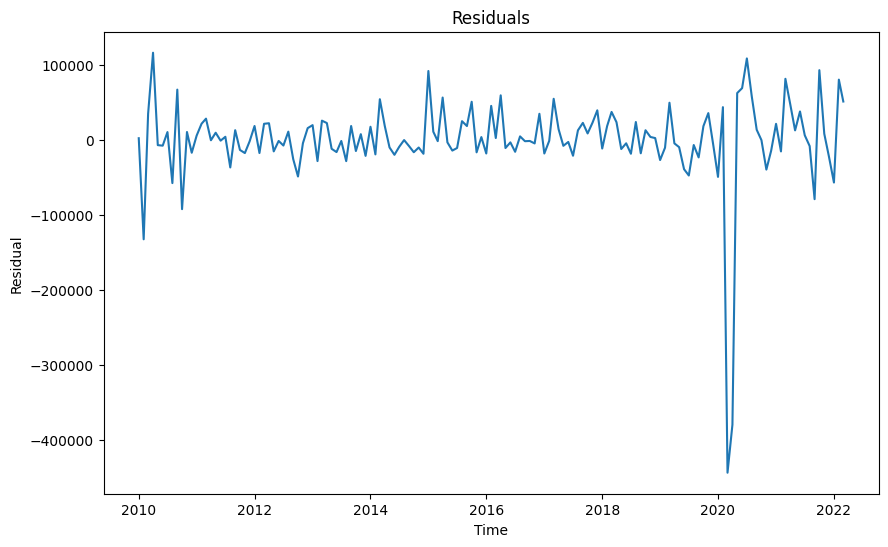

Skewness: -4.434139765075003
Kurtosis: 29.6842439804063
Statistics=0.615, p=0.000


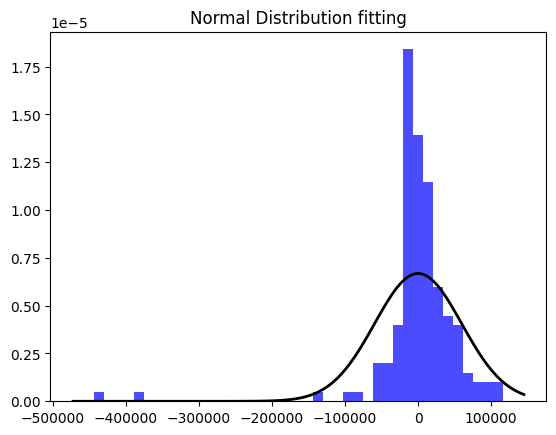

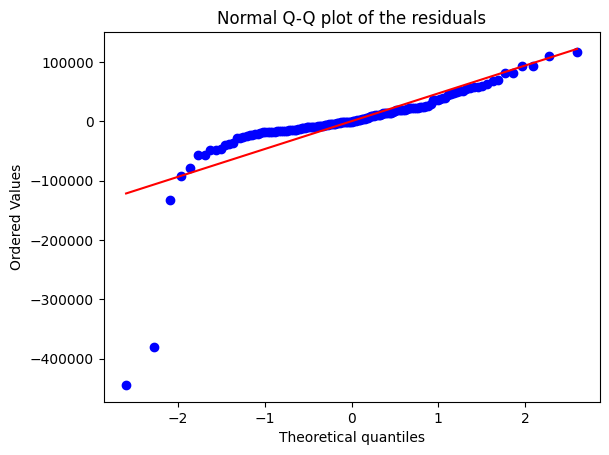

In [150]:

# Skewness and Kurtosis
print('Skewness:', skew(residuals))
print('Kurtosis:', kurtosis(residuals))

# Normality test (Shapiro-Wilk test)
stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))


# Line Plot
residuals = best_model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()

# Histogram
plt.hist(residuals, bins='auto', density=True, color='blue', alpha=0.7)
# Add a fitting normal curve on the histogram
mu, std = stats.norm.fit(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution fitting")
plt.show()

# QQ plot
stats.probplot(residuals, plot=plt)
plt.title("Normal Q-Q plot of the residuals")
plt.show()


### Autocorrelation of Residuals:

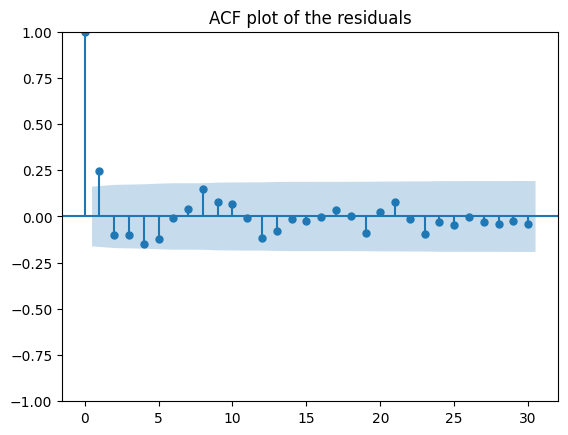

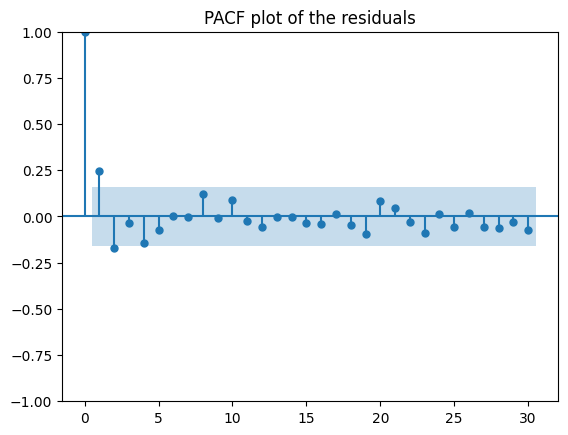

In [151]:

# ACF plot
plot_acf(residuals, lags=30)
plt.title("ACF plot of the residuals")
plt.show()

# PACF plot
plot_pacf(residuals, lags=30)
plt.title("PACF plot of the residuals")
plt.show()


In [153]:

# ACF and PACF values
acf_values = acf(residuals, nlags=30)
pacf_values = pacf(residuals, nlags=30)

# Print these values
for i in range(len(acf_values)):
    print(f'Lag {i}: ACF={acf_values[i]}, PACF={pacf_values[i]}')


Lag 0: ACF=1.0, PACF=1.0
Lag 1: ACF=0.24475047350156098, PACF=0.246426846607736
Lag 2: ACF=-0.09981228057420939, PACF=-0.17238337832530803
Lag 3: ACF=-0.10275892096652482, PACF=-0.036413240068490255
Lag 4: ACF=-0.15050685235221828, PACF=-0.1455519132226297
Lag 5: ACF=-0.12409668465854423, PACF=-0.07707460135364742
Lag 6: ACF=-0.009434737129073908, PACF=0.001290366141279393
Lag 7: ACF=0.03949736018468093, PACF=-0.0025900680437121026
Lag 8: ACF=0.14836785171662167, PACF=0.13128822120351546
Lag 9: ACF=0.07938993588129652, PACF=-0.009934838594348924
Lag 10: ACF=0.06633299821961564, PACF=0.09483993020272413
Lag 11: ACF=-0.010799306206834107, PACF=-0.026959221284185847
Lag 12: ACF=-0.11396646194259256, PACF=-0.06491408776263038
Lag 13: ACF=-0.08100264922866471, PACF=-0.003925879498594732
Lag 14: ACF=-0.01376195946333286, PACF=-0.002532766744442901
Lag 15: ACF=-0.022929828703495404, PACF=-0.038075488560279265
Lag 16: ACF=-0.005402857934847433, PACF=-0.04302847413512633
Lag 17: ACF=0.037669165

### Stationarity

In [104]:

# Perform ADF test
adf_result = adfuller(best_model_fit.resid)
adf_statistic = adf_result[0]
adf_pvalue = adf_result[1]

# Perform KPSS test
kpss_result = kpss(best_model_fit.resid)
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]

# Define threshold values for interpretation
adf_threshold = 0.05  # Threshold for ADF statistic and p-value
kpss_threshold = 0.10  # Threshold for KPSS statistic and p-value

# Interpret ADF test results
print("ADF Test:")
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {adf_pvalue}")
if adf_statistic < adf_threshold and adf_pvalue < adf_threshold:
    print("The residuals are stationary according to the ADF test.")
else:
    print("The residuals are not stationary according to the ADF test.")

# Interpret KPSS test results
print("\nKPSS Test:")
print(f"KPSS Statistic: {kpss_statistic}")
print(f"p-value: {kpss_pvalue}")
if kpss_statistic < kpss_threshold and kpss_pvalue < kpss_threshold:
    print("The residuals are stationary according to the KPSS test.")
else:
    print("The residuals are not stationary according to the KPSS test.")


ADF Test:
ADF Statistic: -8.78626090757787
p-value: 2.304269055454833e-14
The residuals are stationary according to the ADF test.

KPSS Test:
KPSS Statistic: 0.05791313801621315
p-value: 0.1
The residuals are not stationary according to the KPSS test.


/var/folders/6k/0v57cgbd2k37vp0lh44zby640000gn/T/ipykernel_34442/2172574722.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(best_model_fit.resid)


The relevance of conducting the ADF and KPSS tests on the residuals is to assess their stationarity. 

Stationarity is an important assumption in many time series models, including SARIMA and Holt-Winters, as it ensures that the statistical properties of the data remain consistent over time.

In this case, the ADF test suggests that the residuals are stationary, indicating that they do not have a unit root and exhibit a stable pattern. This is desirable for modeling purposes, as it allows for the reliable estimation of model parameters and accurate forecasting.

On the other hand, the KPSS test suggests that the residuals are not stationary, which implies the presence of a trend or structural change in the data. This discrepancy between the ADF and KPSS tests could indicate some underlying complexity in the data that may require further exploration and consideration in the modeling process.

Based on these results, you can proceed with modeling using the assumption of stationarity given by the ADF test. However, it's also important to be mindful of the potential non-stationarity indicated by the KPSS test. You may want to investigate the reasons behind this discrepancy, such as the presence of long-term trends or structural breaks, and consider additional techniques or models that can handle such patterns if needed.



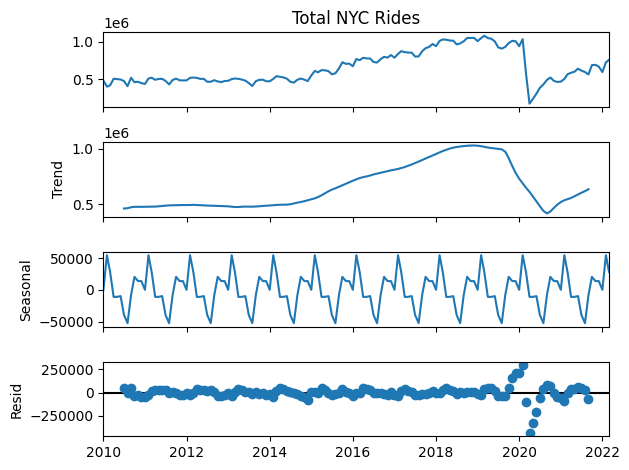

In [105]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Seasonal Decomposition (STL)
result = seasonal_decompose(train, model='additive', period=12)
result.plot()
plt.show()



# Forecasting

In [562]:
# Ensure your series is in float type
series = series.astype(float)

# Set the frequency of the series if not exists
series.index.freq = 'MS'  # set frequency to 'MS' (monthly start)

# Fit the model with the best parameters and fit method on the entire series
final_model = ExponentialSmoothing(series, **best_params['params'])
final_model_fit = final_model.fit(method=best_params['fit_method'])

# Forecast the next 12 months
forecast = final_model_fit.forecast(steps=12)

print("Forecast for the next 12 months:")
print(forecast)
print(test)

Forecast for the next 12 months:
2023-04-01    783596.413285
2023-05-01    783795.998033
2023-06-01    785544.018549
2023-07-01    753098.140471
2023-08-01    741603.955474
2023-09-01    788272.739648
2023-10-01    821055.661720
2023-11-01    813791.245798
2023-12-01    815479.206058
2024-01-01    795482.291094
2024-02-01    846400.516046
2024-03-01    831862.226016
Freq: MS, dtype: float64
Month/Year
2022-06-01    740256.0
2022-07-01    704132.0
2022-08-01    690095.0
2022-09-01    739744.0
2022-10-01    780844.0
2022-11-01    748147.0
2022-12-01    783886.0
2023-01-01    732754.0
2023-02-01    783314.0
2023-03-01    809298.0
Name: Total NYC Rides, dtype: float64


# Percent of Total Rides

In [189]:
# AutoArima AIC Single Vehicle

for license_class in license_classes:
    # Get the time series for this license class
    series = df[df['License Class'] == 'FHV - Black Car']['Percent of Total']
    
    # Split into train and test sets
    train, test = series[:-3], series[-3:]
    
    # Fit model with automatic order selection
    model = auto_arima(train, seasonal=True, trace=False)
    
    # Make predictions
    predictions = model.predict(n_periods=len(test))
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f'Test RMSE for {license_class}: {rmse:.8f}')


Test RMSE for Yellow: 0.00189119
Test RMSE for Green: 0.00189119
Test RMSE for FHV - Lux Limo: 0.00189119
Test RMSE for FHV - Livery: 0.00189119
Test RMSE for FHV - High Volume: 0.00189119
Test RMSE for FHV - Black Car: 0.00189119


Test RMSE for Green: 0.00031276
Test RMSE for FHV - Livery: 0.00170287
Test RMSE for FHV - Black Car: 0.00174895
Test RMSE for FHV - High Volume: 0.00421686
Test RMSE for FHV - Lux Limo: 0.00003907
Test RMSE for Yellow: 0.00698206


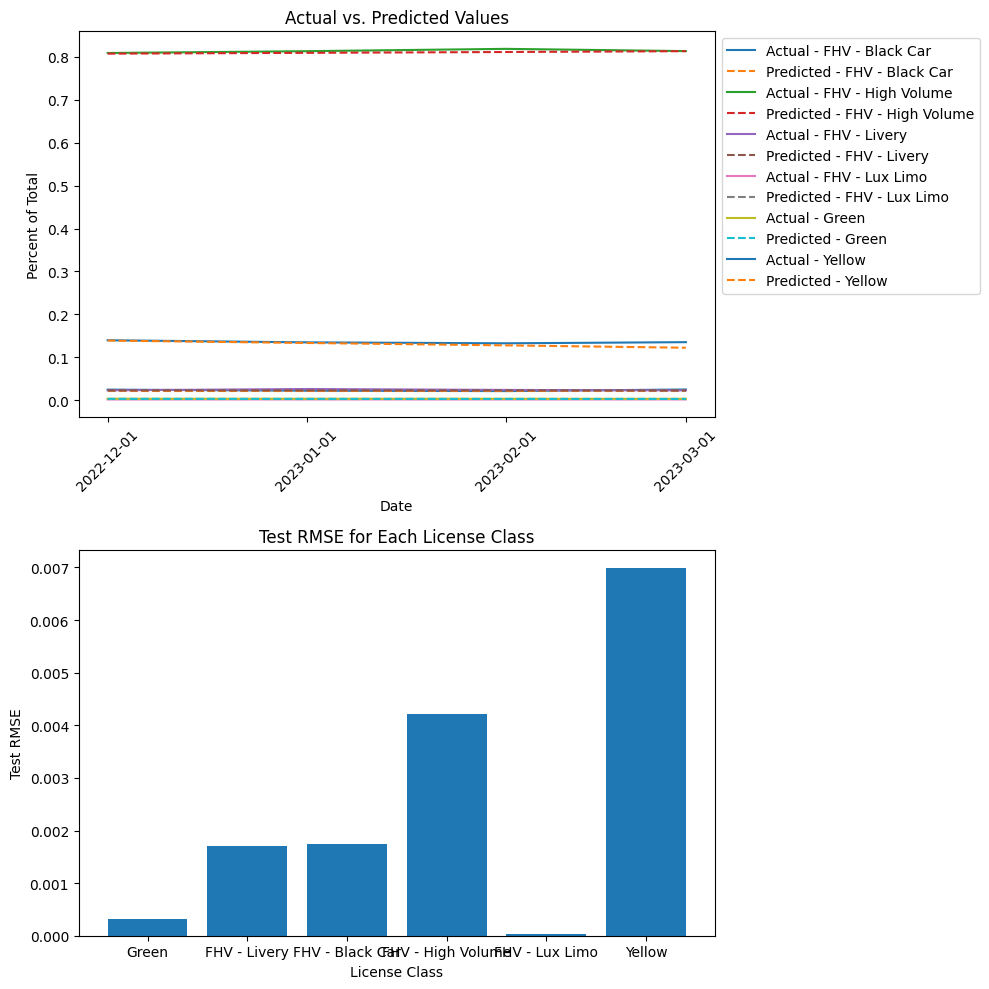

,License Class,Date,Actual,Predicted,Difference
2022-12-01,Green,2022-12-01,0.002980,0.002746,0.000234
2023-01-01,Green,2023-01-01,0.003001,0.002651,0.000350
2023-02-01,Green,2023-02-01,0.002953,0.002599,0.000353
2023-03-01,Green,2023-03-01,0.002870,0.002571,0.000299
2022-12-01,FHV - Livery,2022-12-01,0.022644,0.022675,-0.000032
2023-01-01,FHV - Livery,2023-01-01,0.025729,0.022514,0.003215
2023-02-01,FHV - Livery,2023-02-01,0.023584,0.022462,0.001123
2023-03-01,FHV - Livery,2023-03-01,0.022487,0.022445,0.000043
2022-12-01,FHV - Black Car,2022-12-01,0.024319,0.022168,0.002150
2023-01-01,FHV - Black Car,2023-01-01,0.021805,0.022168,-0.000363


In [270]:
# Create an empty dataframe
results_df = pd.DataFrame(columns=['License Class', 'Date', 'Actual', 'Predicted', 'Difference'])

rmse_values = []

for license_class in license_classes:
    # Get the time series for this license class
    series = df[df['License Class'] == license_class]['Percent of Total']
    
    # Split into train and test sets
    train, test = series[:-4], series[-4:]
    
    # Fit model with automatic order selection
    model = auto_arima(train, seasonal=True, trace=False)
    
    # Make predictions
    predictions = model.predict(n_periods=len(test))
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, predictions))
    rmse_values.append(rmse)
    
    # Create a temporary dataframe with the results for this license class
    temp_df = pd.DataFrame({
        'License Class': license_class,
        'Date': test.index,
        'Actual': test.values,
        'Predicted': predictions,
        'Difference': test.values - predictions
    })
    
    # Append the temporary dataframe to the main results dataframe
    results_df = pd.concat([results_df, temp_df])

    print(f'Test RMSE for {license_class}: {rmse:.8f}')


# Plot the actual and predicted values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
for license_class, data in results_df.groupby('License Class'):
    ax1.plot(data['Date'], data['Actual'], label=f'Actual - {license_class}')
    ax1.plot(data['Date'], data['Predicted'], linestyle='--', label=f'Predicted - {license_class}')
ax1.set_xlabel('Date')
ax1.set_ylabel('Percent of Total')
ax1.set_title('Actual vs. Predicted Values')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.set_xticks(data['Date'].unique())
ax1.set_xticklabels(data['Date'].dt.strftime('%Y-%m-%d').unique(), rotation=45)

# Plot the Test RMSE values
ax2.bar(license_classes, rmse_values)
ax2.set_xlabel('License Class')
ax2.set_ylabel('Test RMSE')
ax2.set_title('Test RMSE for Each License Class')

plt.tight_layout()
plt.show()

# Print the results dataframe
results_df


# Analysis

In [240]:
# AutoArima without Transformation # Test RMSE for Total NYC Rides: 36698.654
# AutoArima AIC Arima with Differencing if Necessary


# Get the time series for 'Total NYC Rides'
series = df['Total NYC Rides'].drop_duplicates()
series = series.reset_index(drop=True)  # Reset the index

# Split into train and test sets
train, test = series[:-10], series[-10:]

# Fit model with automatic order selection
model = auto_arima(train, seasonal=True, trace=False)

# Make predictions
predictions = model.predict(n_periods=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE for Total NYC Rides: {rmse:.3f}')


Test RMSE for Total NYC Rides: 36698.654


In [135]:
# AutoArima ADF Test + Differencing: Test RMSE for Total NYC Rides: 37067.221


# Get the time series for 'Total NYC Rides'
series = df['Total NYC Rides']
series = series.drop_duplicates()
series = series.reset_index(drop=True)  # Reset the index

# Check for stationarity using ADF test
adf_test = adfuller(series)
print('ADF Test Statistic:', adf_test[0])
print('p-value:', adf_test[1])

# Apply differencing if necessary
if adf_test[1] > 0.05:
    series = series.diff().dropna()
    series = series.reset_index(drop=True)  # Reset the index

# Split into train and test sets
train, test = series[:-10], series[-10:]

# Fit model with automatic order selection
model = auto_arima(train, seasonal=True, trace=False)

# Make predictions
predictions = model.predict(n_periods=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE for Total NYC Rides: {rmse:.3f}')


ADF Test Statistic: -2.0664143319026578
p-value: 0.2582321817381398
Test RMSE for Total NYC Rides: 37067.221


ADF Test Statistic: -2.0664143319026578
p-value: 0.2582321817381398
Test RMSE for Total NYC Rides: 37067.221
Ljung-Box Test p-value: 0.2148756830535346
Normality Test p-value: 0.28379542166061755


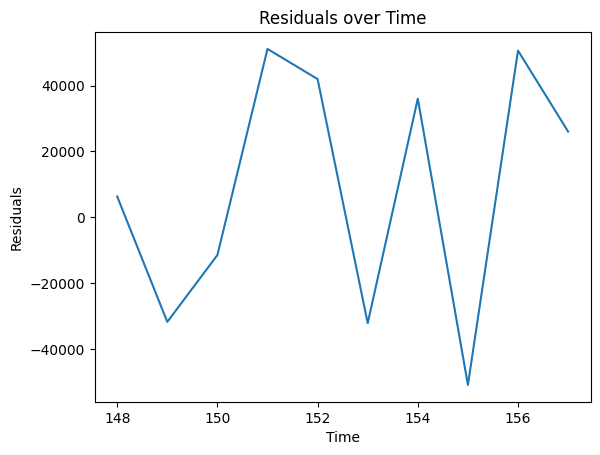

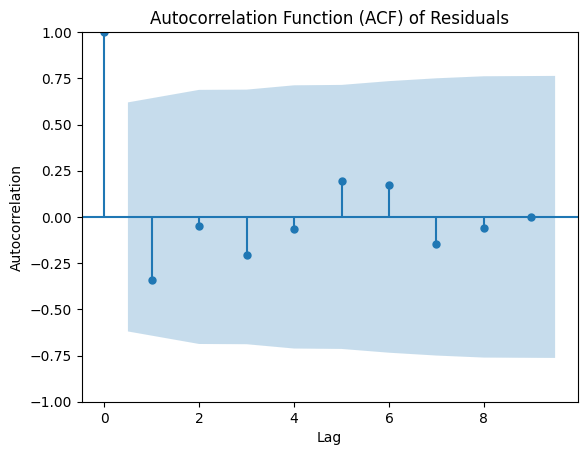

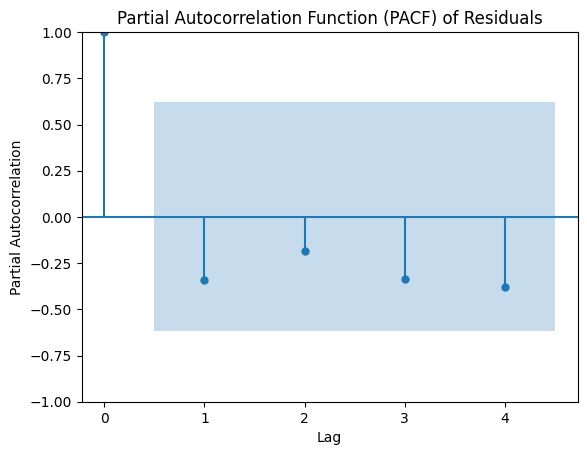

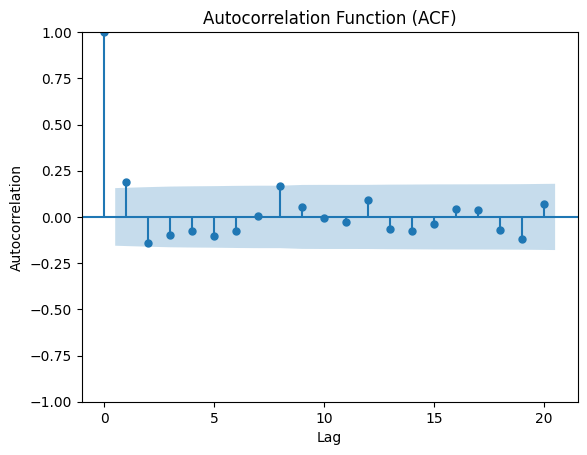

In [289]:
# auto_arima with Differencing if Neccessary and Analysis

# Get the time series for 'Total NYC Rides'
series = df['Total NYC Rides'].drop_duplicates()
series = series.reset_index(drop=True)  # Reset the index

# Check for stationarity using ADF test
adf_test = adfuller(series)
print('ADF Test Statistic:', adf_test[0])
print('p-value:', adf_test[1])

# Apply differencing if necessary
if adf_test[1] > 0.05:
    series = series.diff().dropna()
    series = series.reset_index(drop=True)  # Reset the index

# Split into train and test sets
train, test = series[:-10], series[-10:]

# Fit model with automatic order selection
model = auto_arima(train, seasonal=True, trace=False)

# Make predictions
predictions = model.predict(n_periods=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE for Total NYC Rides: {rmse:.3f}')

# Residual Analysis
residuals = test - predictions
# residuals = model_fit.resid

# Ljung-Box Test
lb_test = acorr_ljungbox(residuals, lags=min(9, len(residuals)-1))
print('Ljung-Box Test p-value:', lb_test['lb_pvalue'].iloc[0])

# Normality Tests
normal_test = normal_ad(residuals)
print('Normality Test p-value:', normal_test[1])

# # Homoscedasticity Test (Breusch-Pagan Test)
# homo_test = het_breuschpagan(residuals, exog_het=None)
# print('Homoscedasticity Test p-value:', homo_test[1])

# Plot the residuals over time
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals over Time')
plt.show()

# ACF and PACF Analysis
lags_acf = min(20, len(residuals)-1)
lags_pacf = min(4, len(residuals)-1)
plot_acf(residuals, lags=lags_acf)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

plot_pacf(residuals, lags=lags_pacf)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.show()

from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation function (ACF)
plot_acf(series, lags=20)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function (ACF)")
plt.show()




residuals = test - predictions

The above code calculates the residuals directly by subtracting the predicted values from the actual values. This is generally used when you've generated predictions on a test set and want to evaluate the residuals of these predictions.

residuals = model_fit.resid

On the other hand, this line of code retrieves the residuals from a fitted model. These residuals are the differences between the actual values and the predicted values for the data that was used to fit the model (i.e., your training set).

